## Part 2: Parameter estimation in a state-space model

In this exercise, we shall develop models to predict the temperature evolution in a transformer station in a DSO (distribution system operator, distributing electricity from high-voltage grid out to the end consumer) grid. Transformer stations are vital to the electricity transportation system, and having the operate optimally is advantagous.
A brief introduction to a transformer station. Roughly speaking, a transformer station receives electricity at a high voltage and sends out electricity at a lower voltage. In this process, some energy is lost in the transformer and converted into heat. 

DSO transformer stations typically use oil for cooling (like water cooling, just with oil). 
The highest temperature inside the transformer station needs to be below a given threshold in order to limit the speed of degradation of the transformer station and to avoid it catching fire. In this data, a good approximation to this temperature is measured. We would now like a model that is able to predict this temperature.

### 2.1

In [1]:
import pandas as pd

df = pd.read_csv('./transformer_data.csv')
df.describe()

,time,Y,Ta,S,I
count,168.000000,168.000000,168.000000,168.000000,168.000000
mean,84.500000,27.650595,10.023115,214.432540,18.179092
std,48.641546,5.455816,2.916687,259.451647,3.662521
min,1.000000,19.828583,4.516667,0.000000,14.386027
25%,42.750000,23.246383,7.866667,0.000000,15.635851
50%,84.500000,26.066717,9.750000,65.416667,16.367102
75%,126.250000,32.201554,12.000000,410.250000,21.212430
max,168.000000,38.923850,17.466667,755.833333,25.362786


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

PARAMETERS = {"col":["Y", "Ta", "S", "I"], "z_col":["Y_z", "Ta_z", "S_z", "I_z"], "tex_col": ["Y_t", "T_{a, t}", "\Phi_{s,t}", "\Phi_{I,t}"], "col_unit":["◦C", "◦C", "W / m^2", "kA"], "col_name":["Transformer Station Temperature", "Outdoor Air Temperature", "Horizontal Global Solar Radiation", "Load on the Transformer Station"]}
for col in PARAMETERS["col"]:
    df[col+"_z"] = (df[col]-df[col].mean())/df[col].std()

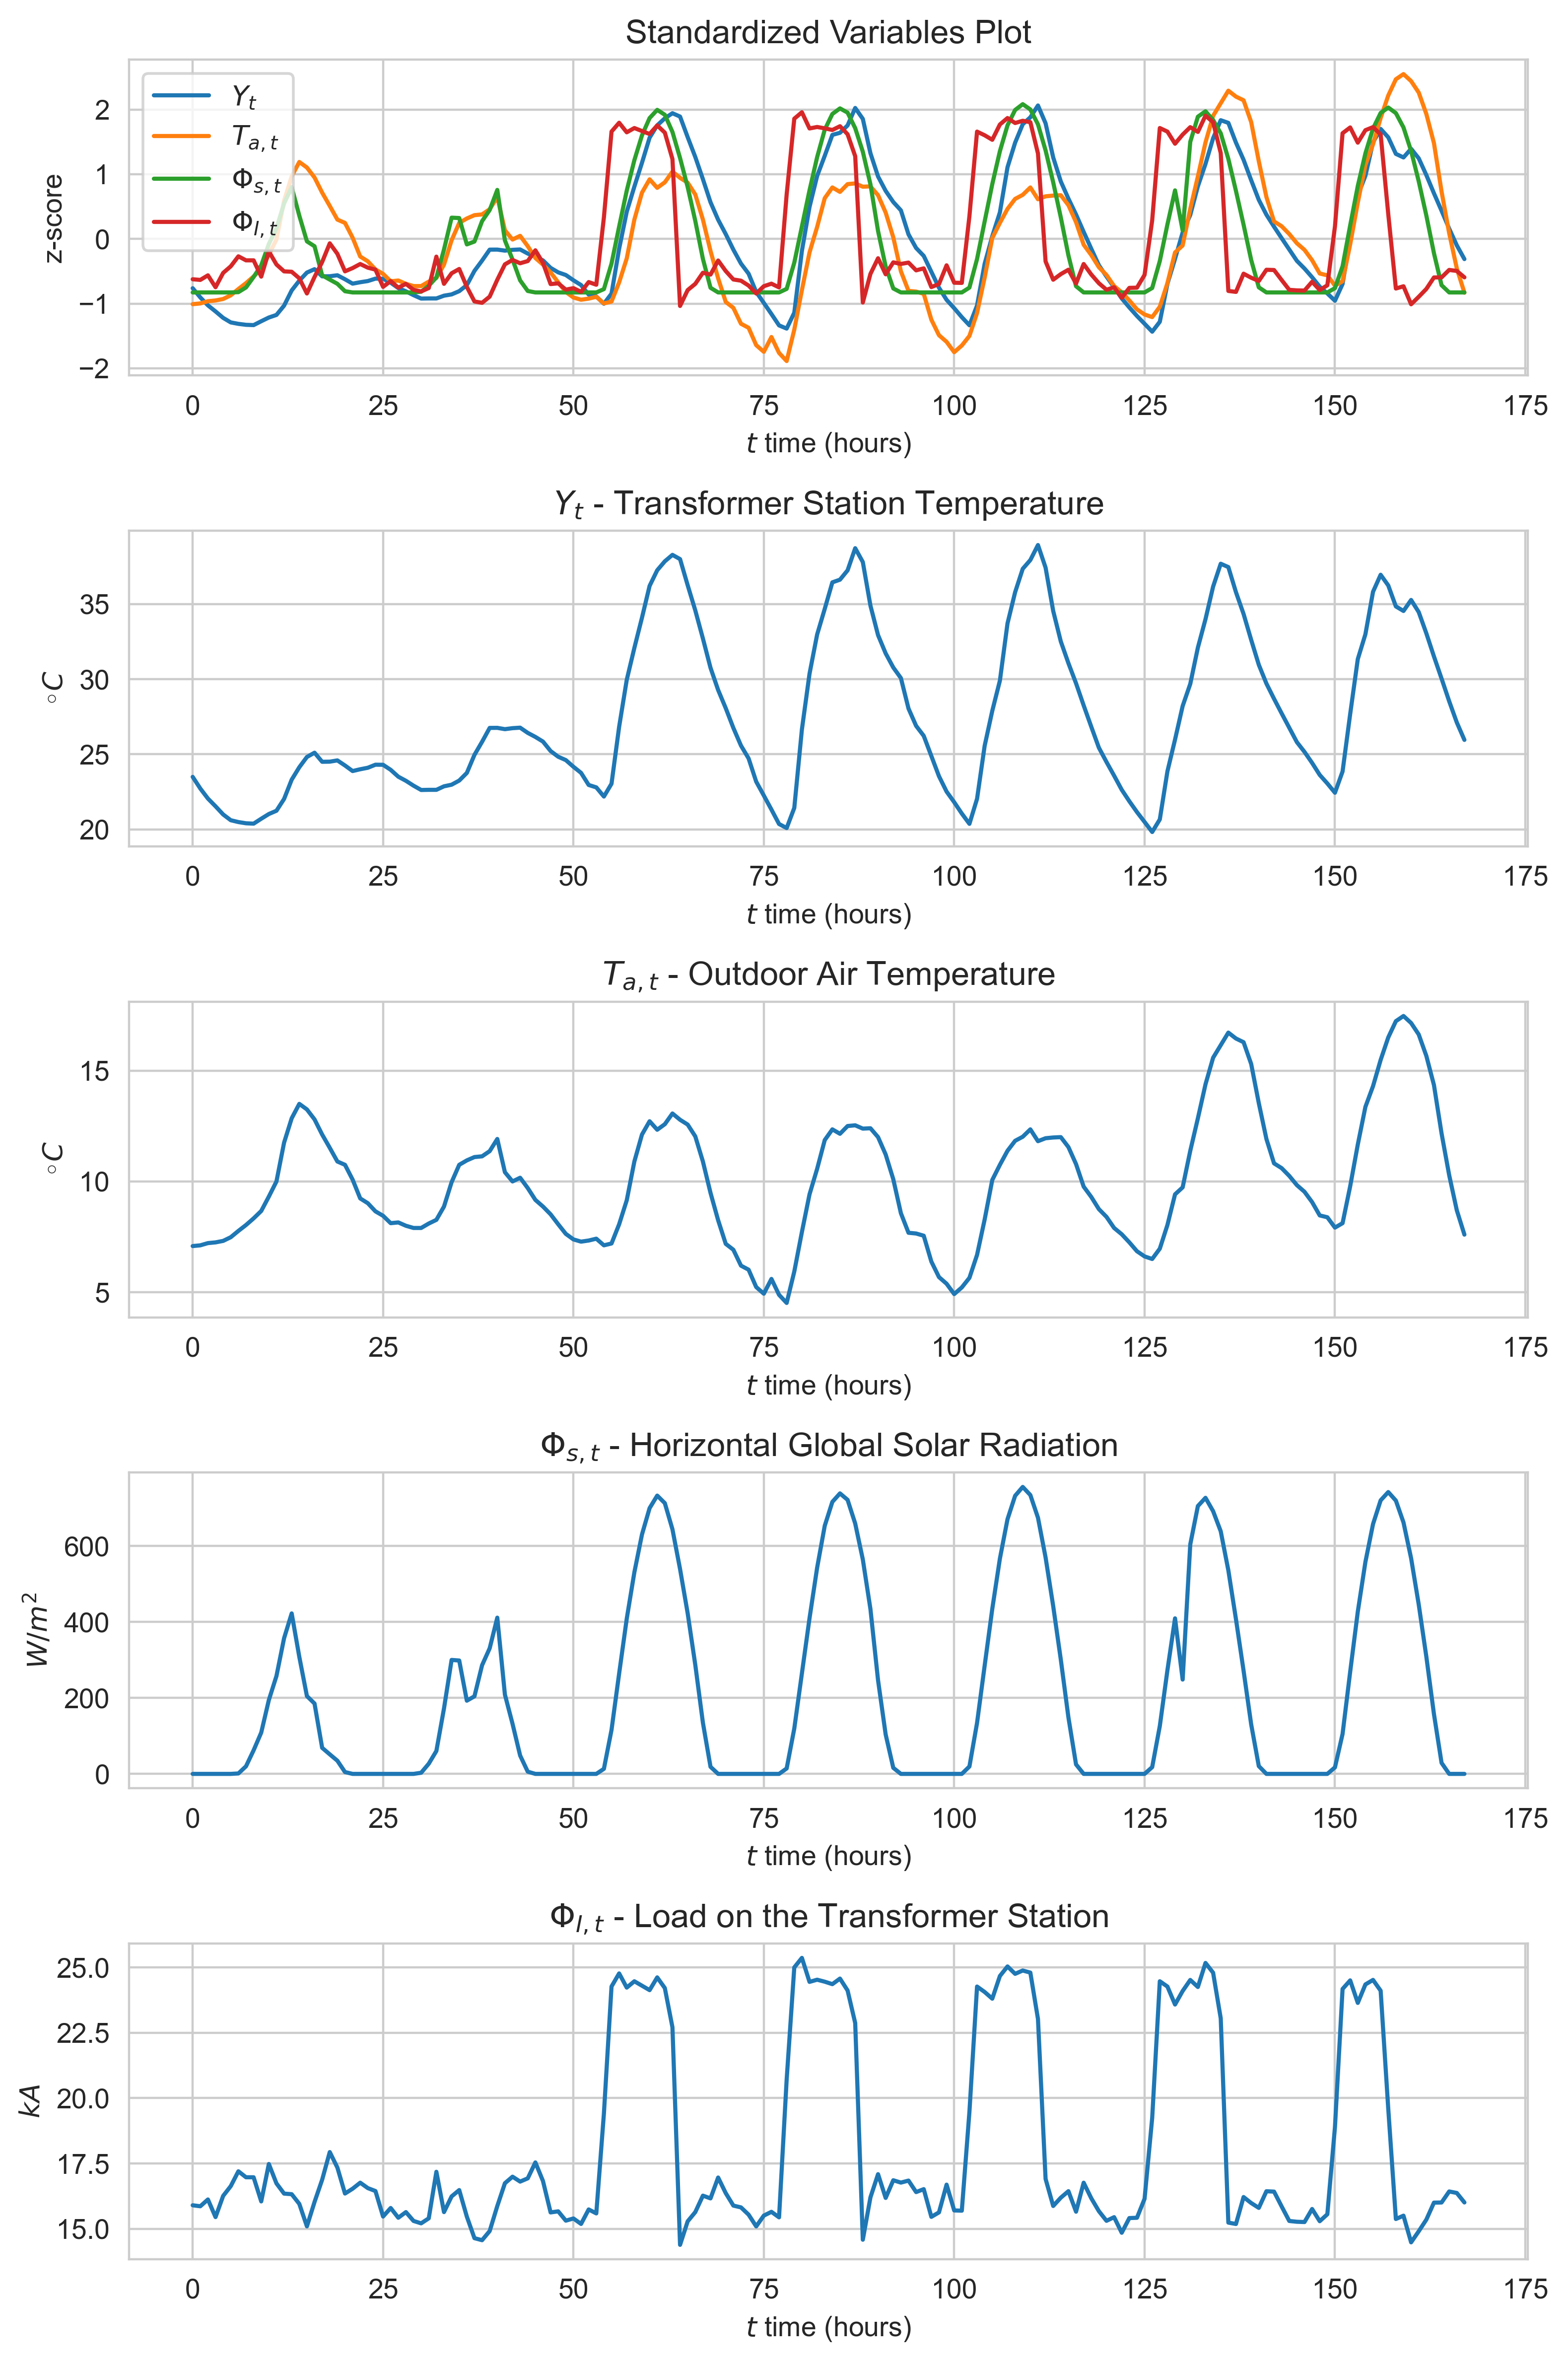

In [3]:
plt.figure(figsize=(8,12), dpi=400)

plt.subplot(5,1,1)
plt.title("Standardized Variables Plot")
for param, tex_param in zip(PARAMETERS["z_col"], PARAMETERS["tex_col"]):
    plt.plot(df[param], label=f"${tex_param}$")
plt.xlabel("$t$ time (hours)")
plt.ylabel("z-score")
plt.legend()

for i, param in enumerate(PARAMETERS["col"]):
    plt.subplot(5,1,i+2)
    plt.title(f'${PARAMETERS["tex_col"][i]}$ - {PARAMETERS["col_name"][i]}')
    plt.plot(df[param])
    plt.xlabel('$t$ time (hours)')
    plt.ylabel(f'${PARAMETERS["col_unit"][i]}$')

plt.tight_layout()

*Comment:*

There is very clearly a seasonality for day/night-cycles in all variables. 
The solar radiation $\Phi_{s,t}$ drops to $0$ during the night, which the load $\Phi_{I,t}$ mirrors almost exactly. It has a slightly quicker drop, once the sun is setting and during the peaks it displays a wiggle, which suggests some sort of load controller or a load maximum with excess being discharged. Lower peaks or crumples in the radiation curve could be explained by cloud cover.
A curious thing to notice, is that the load on the transformer $\Phi_{I,t}$ appears to have a quicker attack-time to rise, than the solar radiation $\Phi_{s,t}$. Intuitively, we would expect the solar radiation to lead and load to lag.
The $Y_t$ temperature follows $\Phi_{s,t}$ showing some cool-down period, once solar radiation dropped, hence a slower decay in temperature.
Outdoor temperature $T_{a,t}$ not only follows the solar radiation, hence daily 24h seasonality, but also exhibits a longer period seasonality, which could be climate and wheather effects.

Overall, we can actually deduce a lot from just outdoor temperature and solar radiation cycles, especially the uninterrupted (unclouded) ones.
When inspecting the graph, we can deduce about 17h of daylight, which excludes locations betwee $\approx \pm 54$ degrees N/S. In the southern-hemisphere there is only 'Tierra de Fuego' the southern cape of Latin America that is still land-mass, but it does not match the temperature profile (as even in summer, for the long daylight hours, it has max. temperatures of about 8 degrees Celsius). One could possible match the outdoor temperature with weather data to deduce a more accurate location.

### 2.2

**Model:**

$$
X_{t+1} = a X_t + B u_t + e_{1,t} \\
Y_t = c X_t + e_{2,t}
$$

* $u_t = [T_{a,t}, \Phi_{s,t}, \Phi_{I,t}]^\top \in \mathbb{R}^{1\times3}$
* $a \in \mathbb{R}, B \in \mathbb{R}^{1\times3}, c \in \mathbb{R}, D \in \mathbb{R}^{1\times3} = 0$ 
* $e_{1,t} \in \mathbb{R}, e_{2,t} \in \mathbb{R}$
* $\Rightarrow X_t \in \mathbb{R}$

For some reason, sigma1 and sigma2 are driven to the lower boundry of the optimizer. Is the system thus just noise free?

In [ ]:
import numpy as np
from project.ssm import kalman_loglik, estimate_ssm_parameters, flatten_params

# generic formulation with the right shapes
A_shape = (1, 1)
B_shape = (1, 3)
C_shape = (1, 1)
D_shape = (1, 3)
Q_shape = (1, 1)
R_shape = (1, 1)
x0_shape = (1,)

start_matrices = (
    np.eye(1)*0.8,              # A - 1
    np.ones((1, 3)) * 0.5,      # B - 3
    np.ones((1, 1)) * (-0.5),   # C - 1
    np.zeros((1, 3)),           # D - 3
    np.eye(1) * 0.5,            # Q - 1
    np.eye(1),                  # R - 1
    np.array([20.0, 20.0])      # x0 - 2
)

start_flat = flatten_params(*start_matrices)
bounds = [(-2, 2)] * 5 + [(0, 0)] * 3 + [(0,3)] * 2 + [(18,23)] * 2 # adjust bounds as needed

# estimate (including the starting value)
result, (A_est, B_est, C_est, D_est, Q_est, R_est, x0_est) = estimate_ssm_parameters(
    kalman_loglik=kalman_loglik,
    Y=df["Y"].values,
    u_df=df[["Ta", "S", "I"]],
    A_shape=A_shape, B_shape=B_shape, C_shape=C_shape, D_shape=D_shape,
    Q_shape=Q_shape, R_shape=R_shape, x0_shape=x0_shape,
    start=start_flat,
    bounds=bounds
)


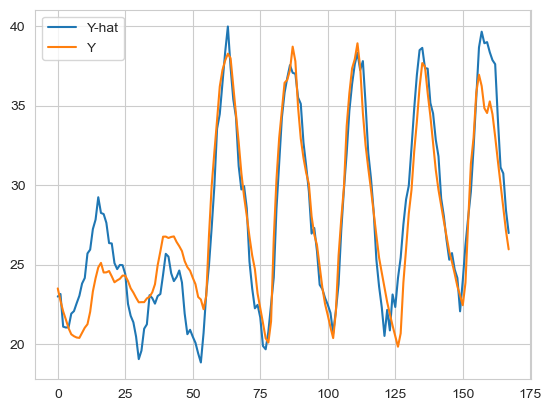

In [20]:
from project.ssm import simulate_ssm
#from project.utils import plot_observations

y, x = simulate_ssm(A_est, B_est, C_est, D_est, Q_est, R_est, df[["Ta", "S", "I"]].values, x0_est)

plt.plot(y, label="Y-hat")
plt.plot(df["Y"], label="Y")
plt.legend()

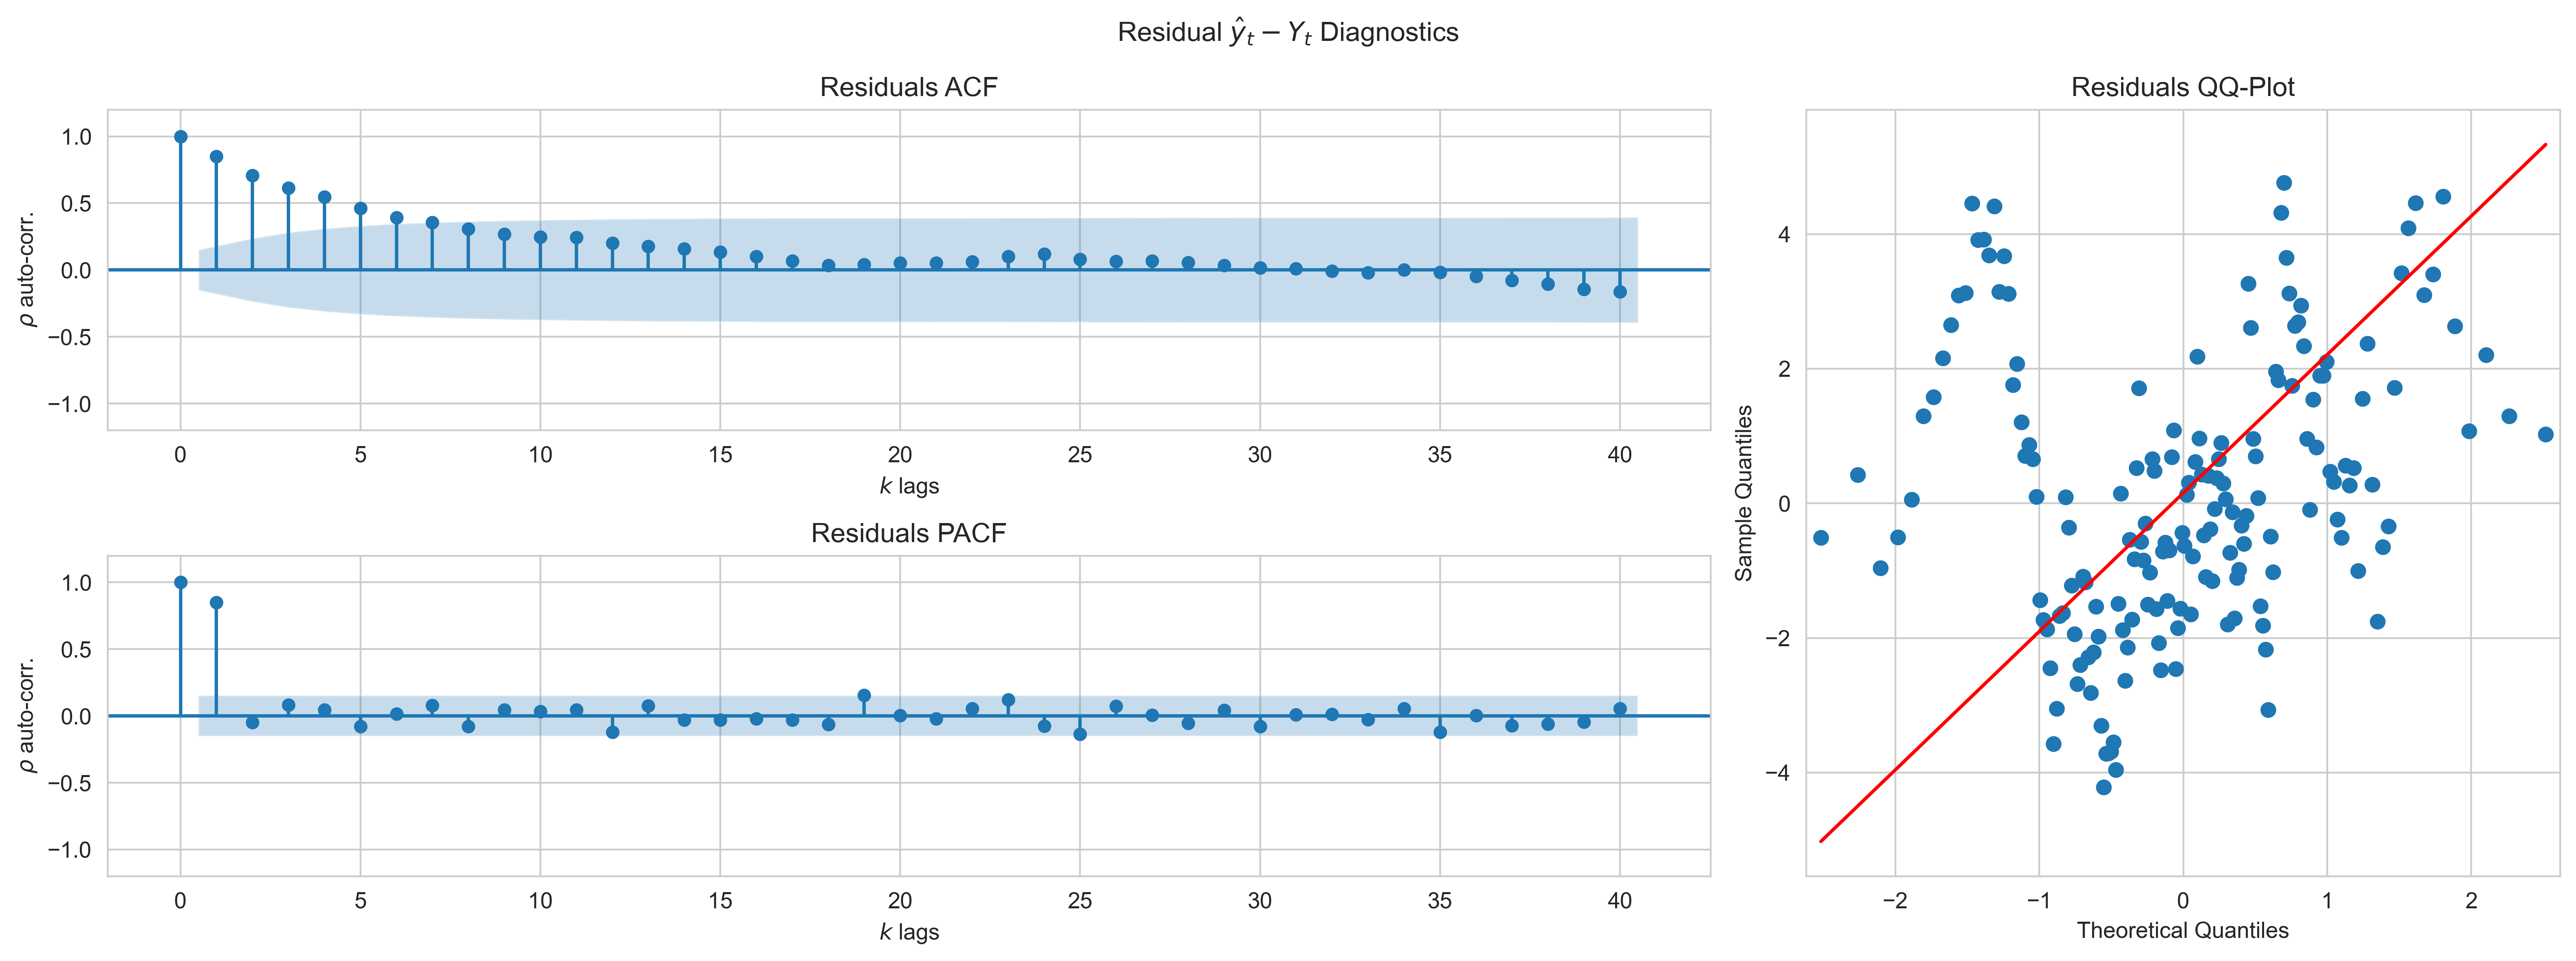

In [21]:
from project.utils import plot_residual_diagnostics

residuals = y - df["Y"].values.reshape(-1,1)
residuals.shape
plot_residual_diagnostics(residuals)

Okay, something the this implementation is clearly not working.

In [14]:
from project.ssm import estimate_1d_state_space, simulate_from_model

# adheres to assignment4 tip; params in [-1,1], x0=20, w/o x0 estimation
res = estimate_1d_state_space(df)
y, x = simulate_from_model(res.x, df)

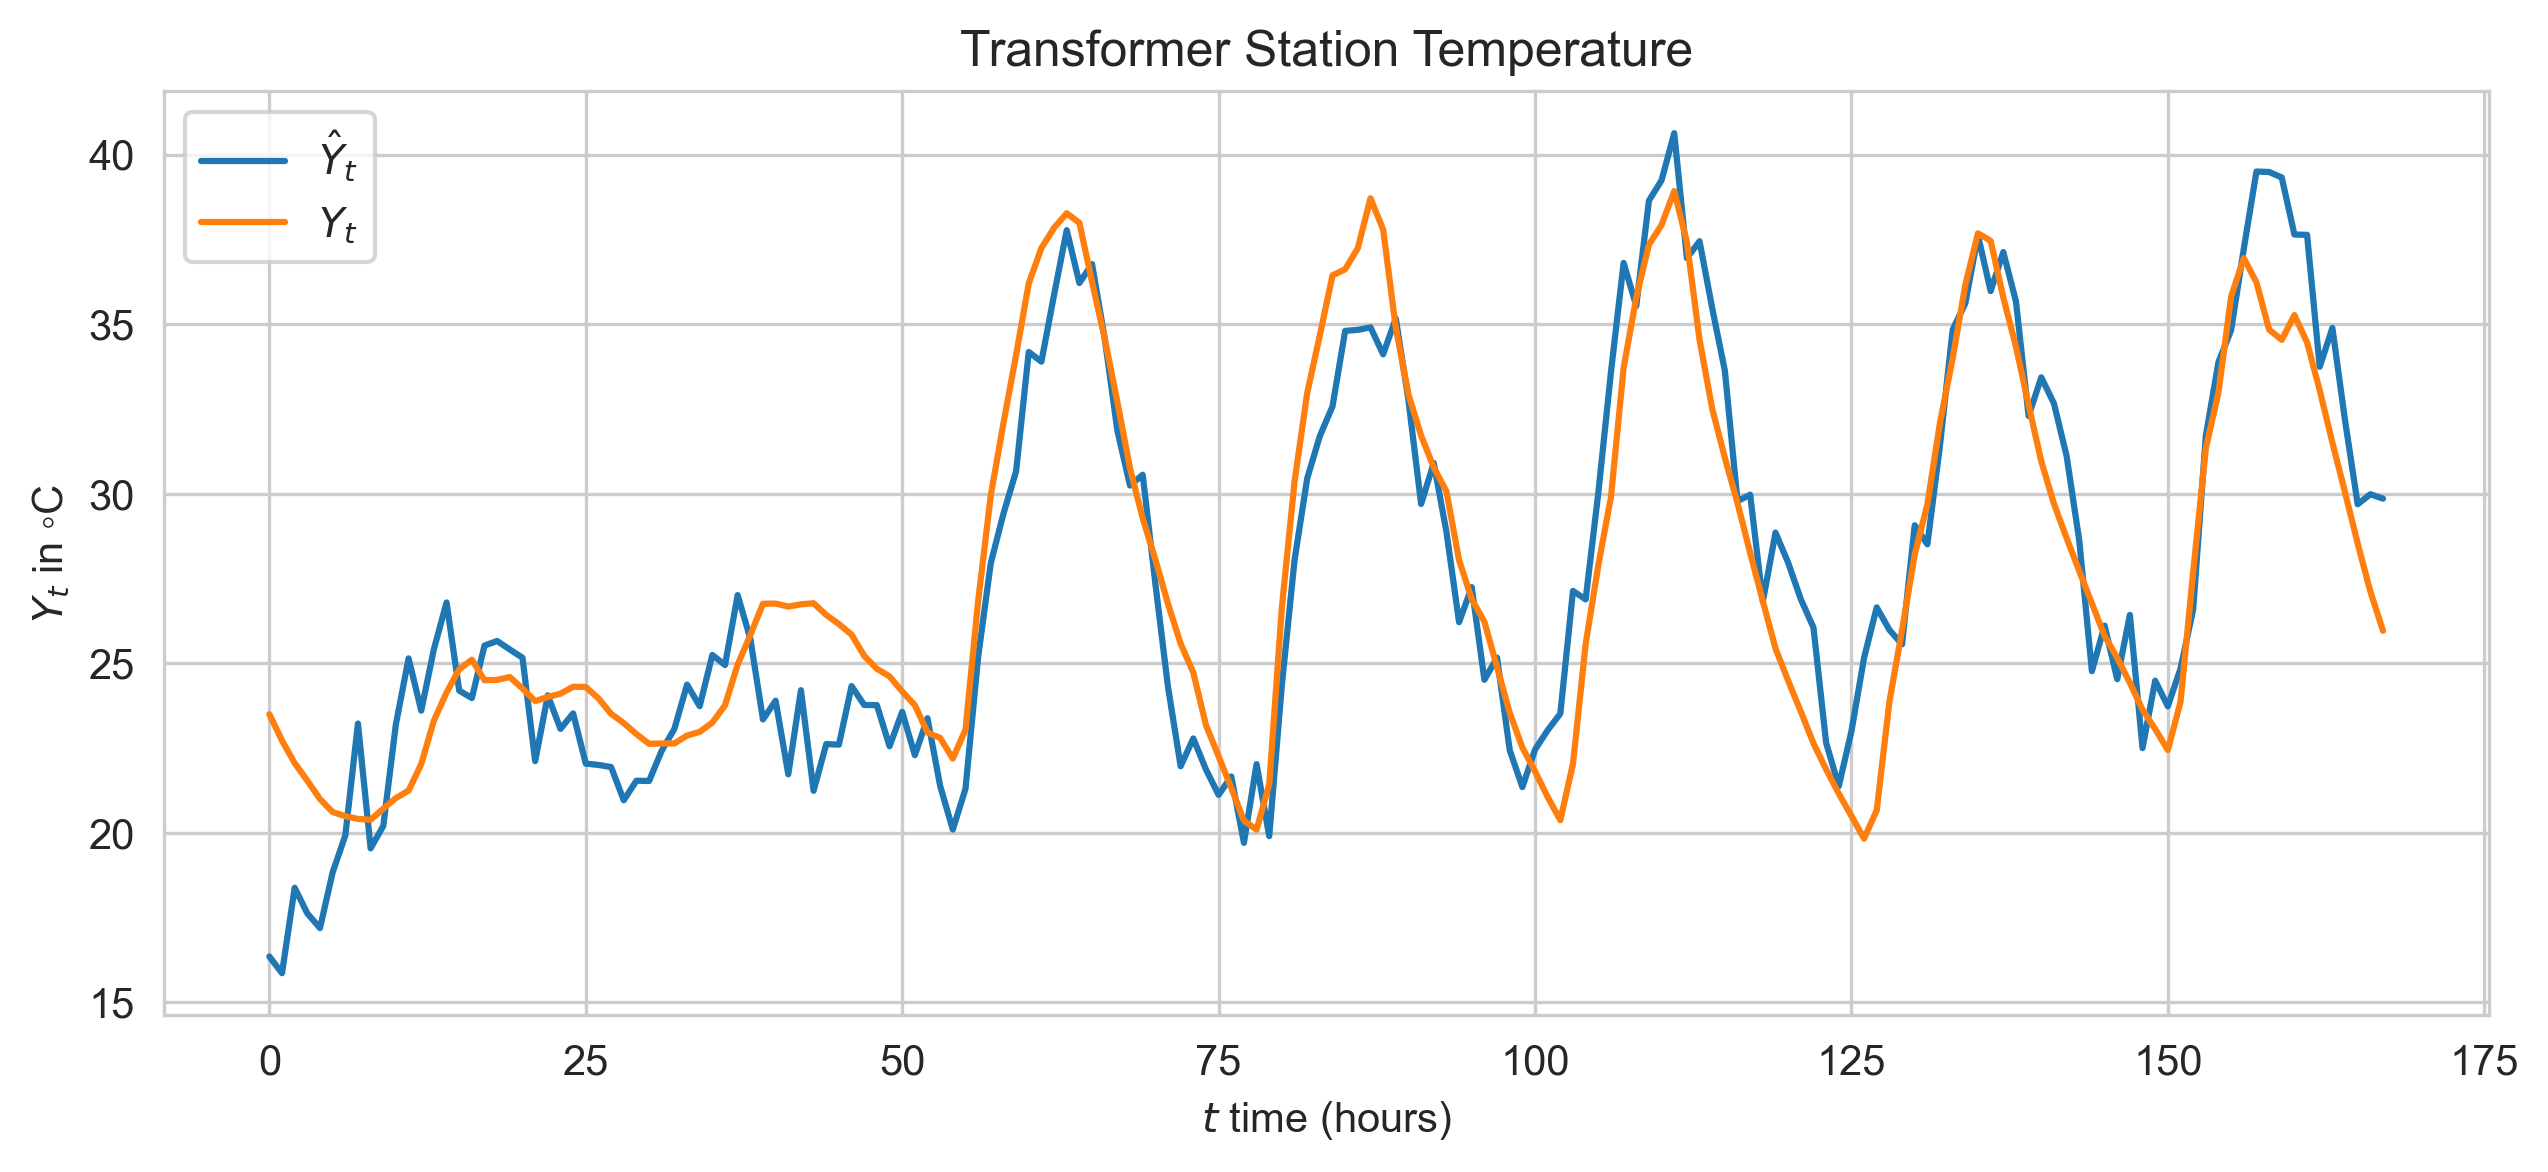

In [17]:
#from project.utils import plot_observations
plt.figure(figsize=(10,4), dpi=300)
plt.title("Transformer Station Temperature")
plt.plot(y, label="$\hat{Y}_t$")
plt.plot(df["Y"], label="$Y_t$")
plt.xlabel("$t$ time (hours)")
plt.ylabel("$Y_t$ in ◦C")
plt.legend()

### 2.3

**2-dim state-space model:**

$$
\mathbf{X}_{t+1} = \mathbf{A} \mathbf{X}_t + \mathbf{B} \mathbf{u}_t + \mathbf{e}_{1,t} \\
Y_t = \mathbf{C} \mathbf{X}_t + \mathbf{D} \mathbf{u}_t + e_{2,t}
$$

* $\mathbf{X}_t \in \mathbb{R}^2$, $\mathbf{u}_t \in \mathbb{R}^3$
* $\mathbf{A} \in \mathbb{R}^{2\times2}, \mathbf{B} \in \mathbb{R}^{2\times3}, \mathbf{C} \in \mathbb{R}^{1\times2}, \mathbf{D} \in \mathbb{R}^{1\times3}=\mathbf{0}$

In [17]:
import numpy as np
from project.ssm import kalman_loglik, estimate_ssm_parameters, flatten_params

# generic formulation with the right shapes
A_shape = (2, 2)
B_shape = (2, 3)
C_shape = (1, 2)
D_shape = (1, 3)
Q_shape = (2, 2)
R_shape = (1, 1)
x0_shape = (2,)

start_matrices = (
    np.eye(2),                  # A - 4
    np.random.rand(2, 3) * 0.1, # B - 6
    np.ones((1, 2)),            # C - 2
    np.zeros((1, 3)),           # D - 3
    np.eye(2) * 0.5,            # Q - 4
    np.array([[1.0]]),          # R - 1
    np.array([20.0, 20.0])      # x0 - 2
)

start_flat = flatten_params(*start_matrices)
bounds = [(-2, 2)] * 12 + [(0, 0)] * 3 + [(0,2)] * 5 + [(15,25)] * 2 # adjust bounds as needed

# estimate (including the starting value)
result, (A_est, B_est, C_est, D_est, Q_est, R_est, x0_est) = estimate_ssm_parameters(
    kalman_loglik=kalman_loglik,
    Y=df["Y"].values,
    u_df=df[["Ta", "S", "I"]],
    A_shape=A_shape, B_shape=B_shape, C_shape=C_shape, D_shape=D_shape,
    Q_shape=Q_shape, R_shape=R_shape, x0_shape=x0_shape,
    start=start_flat,
    bounds=bounds
)


In [18]:
from project.ssm import simulate_ssm

y, x = simulate_ssm(A_est, B_est, C_est, D_est, Q_est, R_est, df[["Ta", "S", "I"]].values, x0_est)

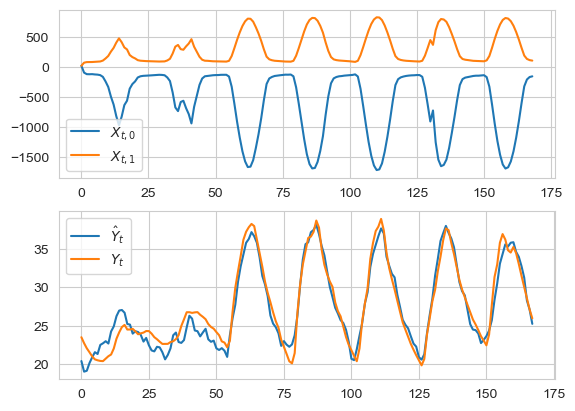

In [22]:
plt.subplot(2,1,1)
plt.plot(x[:,0], label="$X_{t,0}$")
plt.plot(x[:,1], label="$X_{t,1}$")
plt.legend()
plt.subplot(2,1,2)
plt.plot(y, label="$\hat{Y}_t$")
plt.plot(df["Y"], label="$Y_t$")
plt.legend()

The results are extremely volatile towards initial conditions and the hidden states $X_t$ are not at all uniquely determined!

### 2.4

In [ ]:
def reconstruct_states(par, df):
    A = par[0:4].reshape(2, 2)
    B = par[4:10].reshape(2, 3)
    C = par[10:12].reshape(1, 2)
    sigma1 = np.exp(par[12])
    sigma2 = np.exp(par[13])
    
    Y = df["Y"].values
    U = df[["Ta", "S", "I"]].values
    T = len(Y)
    
    x_pred = np.array([20.0, 20.0])
    P_pred = np.eye(2) * 10.0
    
    states = []
    for t in range(T):
        x_pred = A @ x_pred + B @ U[t]
        P_pred = A @ P_pred @ A.T + np.eye(2) * sigma1**2
        
        y_pred = C @ x_pred
        S = C @ P_pred @ C.T + sigma2**2
        innov = Y[t] - y_pred
        
        K = P_pred @ C.T / S
        x_pred = x_pred + K.flatten() * innov
        P_pred = P_pred - K @ C @ P_pred
        states.append(x_pred.copy())
        
    return np.array(states)

# use the previous optimized starting values
x = reconstruct_states(res.x, df)
plt.plot(x)

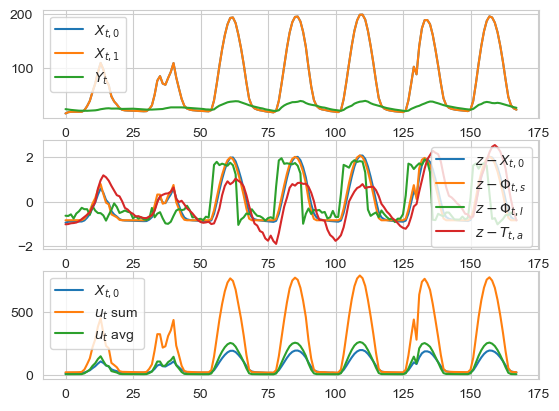

In [65]:
# reconstruct without likelihood
x = reconstruct_states(np.ones(14), df)

# plot hidden states X_t against exogenous variables

plt.subplot(3,1,1)
plt.plot(x[:,0], label="$X_{t,0}$")
plt.plot(x[:,1], label="$X_{t,1}$")
plt.plot(df["Y"], label="$Y_t$")
plt.legend()

plt.subplot(3,1,2)
plt.plot((x[:,0]-np.mean(x[:,0]))/np.std(x[:,0]), label="$z-X_{t,0}$")
plt.plot((df["S"]-df["S"].mean())/df["S"].std(), label="$z-\Phi_{t,s}$")
plt.plot((df["I"]-df["I"].mean())/df["I"].std(), label="$z-\Phi_{t,I}$")
plt.plot((df["Ta"]-df["Ta"].mean())/df["Ta"].std(), label="$z-T_{t,a}$")
plt.legend()

plt.subplot(3,1,3)
plt.plot(x[:,0], label="$X_{t,0}$")
plt.plot(df["S"]+df["I"]+df["Ta"], label="$u_t$ sum")
plt.plot((df["S"]+df["I"]+df["Ta"])/3, label="$u_t$ avg")
plt.legend()

*Conclusion:*

- no optimization and 1-initialized leads to avg of exogenous $u_t$ as state vectors $X_t$ (+/- a little noise)
- of course with correct parameter values A, B, C, D, sigma1, sigma2 initialized, it becomes an accurate reconstruction

**Interpretation Guidance:**

* Plot $X_{1,t}$, $X_{2,t}$ vs. time and against inputs $Ta_t, \Phi_{s,t}, \Phi_{I,t}$
* Analyze:

  * Does one state correlate with load?
  * Does one act as a lagging “thermal buffer”?
* Check sign/magnitude of **B** matrix to infer effect of each input


_________

In [185]:
y, x = simulate_ssm(A_est, B_est, C_est, D_est, Q_est, R_est, df[["Ta", "S", "I"]].values, x0_est)

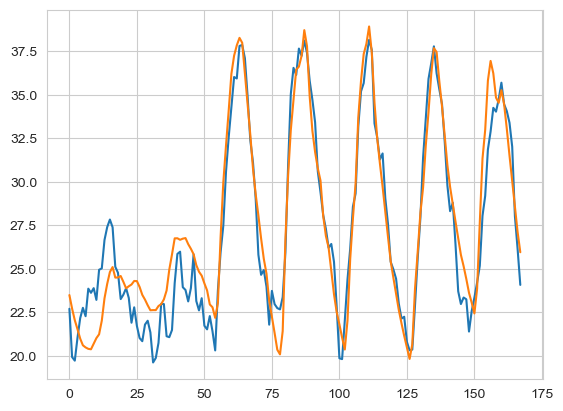

In [186]:
plt.plot(y)
plt.plot(df["Y"])